### Imports and Definitions

In [43]:
from glob import glob
from math import log10
from matplotlib import rcParams
from matplotlib.lines import Line2D
from os import makedirs
from seaborn import pointplot, set_context, set_style, violinplot
from zipfile import ZipFile
import matplotlib.pyplot as plt
ZERO_THRESH = 0.0000000001
DATADIR = '../data'
FIGDIR = '../figs'; makedirs(FIGDIR, exist_ok=True)
RC = {"font.size":12,"axes.titlesize":16,"axes.labelsize":14,"legend.fontsize":10,"xtick.labelsize":10,"ytick.labelsize":10}
set_context("paper", rc=RC); set_style("ticks"); rcParams['font.family'] = 'serif'
rcParams['patch.edgecolor'] = '4C4C4C' # set boxenplot outlines same as violinplot
meta = {
    'time_fn': {
        # 'SEQTK':                      'time.01.seqtk.subsample.txt',
        # 'MINIMAP2':                   'time.02.minimap2.txt',
        # 'SAMTOOLS_SORT_UNTRIMMED':    'time.03.samtools.sort.untrimmed.txt',
        # 'IVAR_TRIM':                  'time.04.ivar.trim.txt',
        # 'SAMTOOLS_SORT_IVAR_TRIMMED': 'time.05.samtools.sort.ivar.trimmed.txt',
        # 'SAMTOOLS_PILEUP':            'time.06.samtools.pileup.txt',
        # 'IVAR_VARIANTS':              'time.07.ivar.variants.txt',
        # 'IVAR_CONSENSUS':             'time.08.ivar.consensus.txt',
        # 'AMPLIPY_TRIM':               'time.09.amplipy.trim.txt',
        # 'AMPLIPY_VARIANTS':           'time.10.amplipy.variants.txt',
        # 'AMPLIPY_CONSENSUS':          'time.11.amplipy.consensus.txt',
        'AMPLIPY_AIO':                'time.12.amplipy.aio.txt',
    },
    
    
    'label': {
        'amplipy_aio': 'AmpliPy (AIO)',
        # 'ivar_pipeline': 'iVar (Pipeline)',
        'time': 'Total Runtime (s)',
        'mem': 'Peak Memory (MB)',
        # 'ratio_time': 'iVar/AmpliPy Runtime Ratio',
        # 'ratio_mem': 'iVar/AmpliPy Peak Memory Ratio',
        
    },
    
    'color': {
        # 'amplipy_aio': 'green',
        # 'ivar_pipeline': 'red',
        # 'ratio': 'black',
        1: 'red',
        3: 'orange',
        4: 'yellow',
        6: 'green',
        8: 'cyan',
        10: 'blue',
        12: 'indigo',
        16: 'violet',
    },
    
    'linestyle': {
        'amplipy_aio': '-',
        # 'ivar_pipeline': '--',
        # 'ratio': '-',
    },
    
    'steps': {
        'ivar_pipeline': ['SAMTOOLS_SORT_UNTRIMMED', 'IVAR_TRIM', 'SAMTOOLS_SORT_IVAR_TRIMMED', 'SAMTOOLS_PILEUP', 'IVAR_VARIANTS', 'IVAR_CONSENSUS'],
        'amplipy_aio': ['AMPLIPY_AIO'],
        'iVar (Variants + Consensus)': ['SAMTOOLS_SORT_IVAR_TRIMMED', 'SAMTOOLS_PILEUP', 'IVAR_VARIANTS', 'IVAR_CONSENSUS'],
        'AmpliPy (Variants + Consensus)': ['AMPLIPY_VARIANTS', 'AMPLIPY_CONSENSUS'],
    },
}

### Helper: Convert Power of 10 to Scientific Notation

In [4]:
def sci_not_mult10(n):
    p = log10(n)
    assert abs(p-int(p)) < ZERO_THRESH, "Not a power of 10: %s" % n
    return r'$10^%d$' % p

### Helper: Parse `/usr/bin/time` Output

In [5]:
def parse_time_output(lines):
    t = None; m = None
    for l in lines:
        if l.strip().startswith('Elapsed (wall clock) time (h:mm:ss or m:ss)'):
            parts = l.split()[-1].split(':')
            if len(parts) == 3: # h:mm:ss
                t = float(parts[0])*3600 + float(parts[1])*60 + float(parts[2])
            elif len(parts) == 2: # m:ss
                t = float(parts[0])*60 + float(parts[1])
            else:
                assert False, "Invalid time: %s" % ':'.join(parts)
        elif l.strip().startswith('Maximum resident set size (kbytes)'):
            m = int(l.split()[-1]) / 1024 # store peak memory as MB instead of KB
    assert t is not None, "Failed to parse runtime"
    assert m is not None, "Failed to parse peak memory"
    return t, m

### Load Data from Zips

In [6]:
data = dict()
for z_fn in glob('%s/p*/n*/p*.n*.r*.zip' % DATADIR):
    p = int(z_fn.split('/')[-1].split('.')[0].lstrip('p'))
    n = int(z_fn.split('/')[-1].split('.')[1].lstrip('n'))
    r = int(z_fn.split('/')[-1].split('.')[2].lstrip('r'))
    z = ZipFile(z_fn)
    if p not in data:
        data[p] = dict()
    if n not in data[p]:
        data[p][n] = dict()
    if r not in data[p][n]:
        data[p][n][r] = dict()
    for comp_fn in z.namelist():
        if comp_fn.startswith('time.'):
            t, m = parse_time_output(z.read(comp_fn).decode().splitlines())
            data[p][n][r][comp_fn] = {'time':t, 'mem':m}

### Plot Pipeline Runtime and Peak Memory vs. *n*

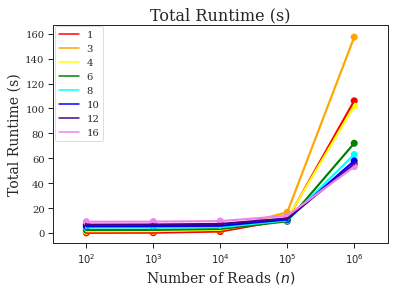

In [50]:
for plot in ['time']:
    fig, ax = plt.subplots(); handles = list()
    for processes in sorted(data.keys()):
        handles.append(Line2D([0],[0],color=meta['color'][processes],label=str(processes),linewidth=1.5,linestyle='-'))
        x = list(); y = list()
        for n in sorted(data[processes].keys()):
            for r in sorted(data[processes][n].keys()):
                x.append(sci_not_mult10(n))
                if plot == 'time':
                    y.append(data[processes][n][r][meta['time_fn']['AMPLIPY_AIO']][plot])
                elif plot == 'mem':
                    y.append(max(data[processes][n][r][meta['time_fn'][step]][plot] for step in meta['steps']['amplipy_aio']))
        pointplot(x=x, y=y, color=meta['color'][processes], linestyles='-')
    plt.xlabel(r'Number of Reads $\left(n\right)$')
    plt.ylabel(meta['label'][plot])
    plt.title(meta['label'][plot])
    #ax.set_yscale('log')
    plt.legend(handles=handles,bbox_to_anchor=(0.005, 0.995), loc=2, borderaxespad=0., frameon=True)
    fig.savefig('%s/%s.pdf' % (FIGDIR, plot), format='pdf', bbox_inches='tight')